##### The original coefficient matrix from polynomial measurement model and its partial derivative on coordinate (x, y) shall be provided

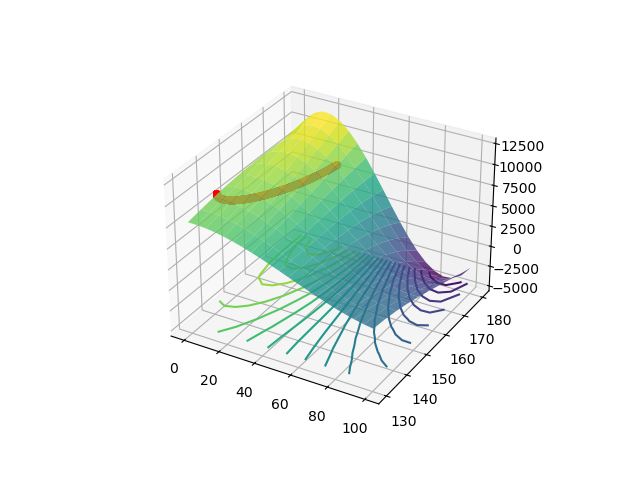

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# basic configuration

arc_length = 70     # unit: mm
step_size = 0.01    # Smaller step size for finer control
start_hight = 180   # whisker base root hight under current frame

coeff = np.array([-3.16722556e-01, -1.82496011e+01,  1.21818472e+00, -4.70079636e-03,
        1.92837276e+00,  1.44167553e+01, -2.23303285e-01,  8.66299481e-04,
        5.60941124e+01, -1.51143032e+00,  1.34277641e-02, -4.01178476e-05,
       -6.35580045e-01,  1.52306920e-02, -1.23081179e-04,  3.39171958e-07])     # cofficient matrix of 5 order bivariate polynomial model

# Dyx: start point suppose to be quite hard to define, since the base rotate and linear translate. A FEA could be introduced to analyze the magnet movement.

def calculate_startpoint(z, h):
    """ Calculate the start point on the polynomial surface with given y coordinate and measurement. """
    
    x = sp.symbols('x')
    polynomial = 3.39171957710271e-7*x**3*h**3 - 0.000123081179238376*x**3*h**2 + 0.0152306919640345*x**3*h - 0.635580045012618*x**3 - 4.01178475646262e-5*x**2*h**3 + 0.0134277640955505*x**2*h**2 - 1.51143031829683*x**2*h + 56.0941123551036*x**2 + 0.000866299480777101*x*h**3 - 0.223303284799815*x*h**2 + 14.4167552841376*x*h + 1.92837275763761*x - 0.00470079635785575*h**3 + 1.2181847239872*h**2 - 18.249601064668*h - 0.316722556202559-z
    x_solution = sp.solveset(polynomial, x, domain=sp.S.Reals)
    return [sol for sol in x_solution if sol >= 0 and sol <= 50]

def z_polyval(x, y, coeff):
    """ Function representing the surface z = f(x, y). """
    
    return np.polynomial.polynomial.polyval2d(x, y, coeff.reshape((4, 4)))

def gradient_z(x, y):
    """ Gradient of the function f(x, y). """ 
    
    dzdx = 1.01751587313081e-6*x**2*y**3 - 0.000369243537715127*x**2*y**2 + 0.0456920758921035*x**2*y - 1.90674013503785*x**2 - 8.02356951292525e-5*x*y**3 + 0.026855528191101*x*y**2 - 3.02286063659366*x*y + 112.188224710207*x + 0.000866299480777101*y**3 - 0.223303284799815*y**2 + 14.4167552841376*y + 1.92837275763761
    dzdy = 1.01751587313081e-6*x**3*y**2 - 0.000246162358476751*x**3*y + 0.0152306919640345*x**3 - 0.000120353542693879*x**2*y**2 + 0.026855528191101*x**2*y - 1.51143031829683*x**2 + 0.0025988984423313*x*y**2 - 0.446606569599629*x*y + 14.4167552841376*x - 0.0141023890735672*y**2 + 2.4363694479744*y - 18.249601064668
    return np.array([dzdx, dzdy], dtype=np.float64)

def loss_gradient_z(x, y, target_z):
    """ Gradient of the squared error loss function. """
    
    error = z_polyval(x, y, coeff) - target_z
    grad_z = gradient_z(x, y)
    return 2 * error * grad_z

def titap_contact_est_gradientdescent(target_z, start_hight, step_size, arc_length):    # only variable here : target_z - sampled data from sensor
    """ Performs constrained gradient descent to move along a level curve, adjusting by loss. """
    
    # Initialize the start position, path and arc distance
    x = float(calculate_startpoint(target_z, start_hight)[0])
    y = start_hight
    path = [(x, y)]     # Just delete this variable and return (x, y) if you only need the contact position 
    delta_dis = 0
    
    while True and delta_dis <= arc_length:
        
        grad_loss = loss_gradient_z(x, y, target_z)
        # Move in direction that minimizes the loss, correcting direction
        loss_direction = np.array([grad_loss[0], grad_loss[1]])
        loss_direction /= np.linalg.norm(loss_direction) # Normalize to step size
        
        grad_tangent = gradient_z(x, y)
        # Move in direction perpendicular to gradient: Rotate gradient by 90 degrees
        tangent_direction = np.array([-grad_tangent[1], grad_tangent[0]])
        tangent_direction /= np.linalg.norm(tangent_direction) # Normalize to step size
        
        dx = step_size * (tangent_direction[0] - loss_direction[0])
        dy = step_size * (tangent_direction[1] - loss_direction[1])
        delta_dis += np.sqrt(dx**2 + dy**2)
        
        x += dx
        y += dy
        
        path.append((x, y)) 
        
    return np.array(path)

# Implementation
    
arc = titap_contact_est_gradientdescent(target_z=8536.9998, 
                                    start_hight=start_hight, 
                                    step_size=step_size, 
                                    arc_length=arc_length)

%matplotlib widget

x = np.linspace(0, 100, 21)
y = np.linspace(130, 180, 10)

X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Plot surface
surface = np.polynomial.polynomial.polygrid2d(x, y, coeff.reshape((4, 4)))
surf = ax.plot_surface(X, Y, surface.T, cmap="viridis", alpha=0.8)

# Plot contour lines on the surface
num_levels = 20
contour_levels = np.linspace(np.min(surface), np.max(surface), num_levels)
contour_surf = ax.contour(X, Y, surface.T, levels=contour_levels, offset=np.min(surface), cmap='viridis')

zs = np.full(arc.shape[0], 8536.9998)
ax.scatter(arc[:, 0], arc[:, 1], zs, color='r')

plt.show()